In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

%matplotlib inline

In [4]:
def display_images(images):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis(False)


(-0.5, 2047.5, 1079.5, -0.5)

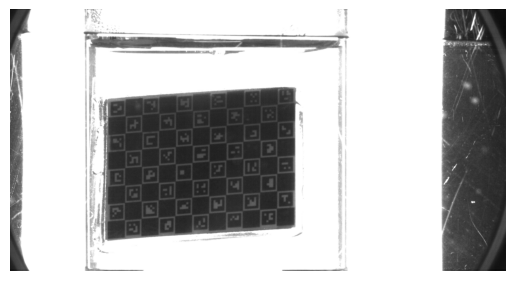

In [13]:
# load images
raw_images = [cv2.imread('../images/cylinder_telecentric/cyl1_exposure30000_360frames_flat/{}.png'.format(i)) for i in range(1, 361)]
plt.imshow(raw_images[0])
plt.axis(False)

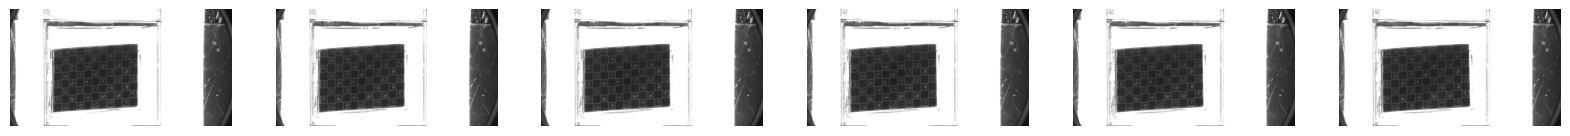

In [14]:
display_images(raw_images[0:6])

360 images in total. Each image with size of (1080, 2048).


(-0.5, 2047.5, 1079.5, -0.5)

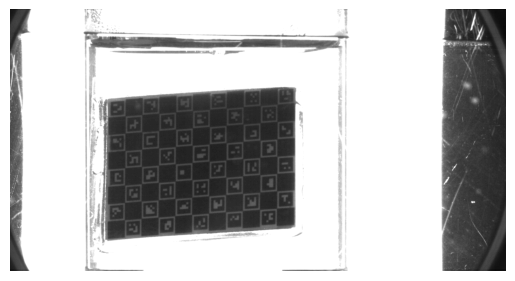

In [18]:
# convert to grayscale
images = [cv2.cvtColor(raw_image,cv2.COLOR_BGR2GRAY) for raw_image in raw_images]
print(f"{len(images)} images in total. Each image with size of {images[0].shape}.")
plt.imshow(images[0],cmap='gray')
plt.axis(False)

In [19]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
(squaresX, squaresY) = (8, 11)
objp = np.zeros(((squaresX-1) * (squaresY-1), 3), np.float32)
objp[:, :2] = np.mgrid[0:(squaresX-1), 0:(squaresY-1)].T.reshape(-1,2)
objp.shape

(70, 3)

In [20]:
(squareLength, markerLength) = (48/11, 18.75*48/11/24)
print(f'squareLength = {squareLength} mm')
print(f'markerLength = {markerLength} mm')

squareLength = 4.363636363636363 mm
markerLength = 3.4090909090909087 mm


In [21]:
# create charuco board
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)
board

< cv2.aruco.CharucoBoard 000002A1AF420D90>

In [22]:
detector = cv2.aruco.CharucoDetector(board)
detector

< cv2.aruco.CharucoDetector 000002A1AD13FCB0>

In [29]:
# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# plt.figure(figsize=(10,200))
# loop over all image paths
for i in range(len(images)):
    gray = images[i]
    
    # find aruco markers
    charuco_corners, charuco_ids, _, _ = detector.detectBoard(gray)
    if charuco_corners is not None:
        if len(charuco_corners) == 0:
            continue
    
    if charuco_corners is not None:
        print(f"Image #{i}: detected {len(charuco_corners)} corner(s) among {objp.shape[0]} corners.")
        # display
        # plt.subplot(int(len(images)/5), 5, i + 1)
        # plt.imshow(images[i], cmap=plt.cm.gray)
        # plt.scatter(charuco_corners[:, 0, 0], charuco_corners[:, 0, 1], color='r')
        # plt.axis(False)

    if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) > 6 and len(charuco_ids) > 6:
        # store object points and image points
        objp_ = objp[charuco_ids]
        # print(objp_.shape, charuco_corners.shape)
        objpoints.append(objp_)
        imgpoints.append(charuco_corners)


Image #0: detected 39 corner(s) among 70 corners.
Image #1: detected 31 corner(s) among 70 corners.
Image #2: detected 42 corner(s) among 70 corners.
Image #3: detected 39 corner(s) among 70 corners.
Image #4: detected 31 corner(s) among 70 corners.
Image #5: detected 33 corner(s) among 70 corners.
Image #6: detected 29 corner(s) among 70 corners.
Image #7: detected 28 corner(s) among 70 corners.
Image #8: detected 23 corner(s) among 70 corners.
Image #9: detected 30 corner(s) among 70 corners.
Image #10: detected 31 corner(s) among 70 corners.
Image #11: detected 25 corner(s) among 70 corners.
Image #12: detected 20 corner(s) among 70 corners.
Image #13: detected 24 corner(s) among 70 corners.
Image #14: detected 24 corner(s) among 70 corners.
Image #15: detected 32 corner(s) among 70 corners.
Image #16: detected 26 corner(s) among 70 corners.
Image #17: detected 21 corner(s) among 70 corners.
Image #18: detected 25 corner(s) among 70 corners.
Image #19: detected 14 corner(s) among 70

In [30]:
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None, flags=(cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_FIX_FOCAL_LENGTH + cv2.CALIB_SAME_FOCAL_LENGTH + cv2.CALIB_ZERO_TANGENT_DIST))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [31]:
ret,mtx, dist

(0.9625694250218914,
 array([[4.45988874e+04, 0.00000000e+00, 1.03912508e+03],
        [0.00000000e+00, 5.07972303e+04, 5.79393284e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-1.21181970e+01, -8.50262951e+02,  1.15658262e-01,
          6.09639654e-02, -8.85325943e-01]]))

In [32]:
len(rvecs), len(tvecs)

(80, 80)

Text(0, 0.5, 'error')

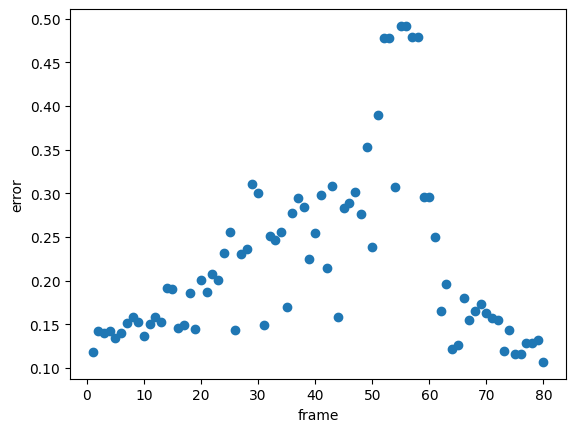

In [33]:
def error_evaluation(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    error_df = pd.DataFrame({'error':[0]})
    for i in range(len(objpoints)):
        # Project object points to image plane
        reprojectedPoints, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        
        img_points = imgpoints
        error = cv2.norm(img_points[i], reprojectedPoints, cv2.NORM_L2) / len(reprojectedPoints)
        new_data = pd.DataFrame({'error':[error]})
        error_df = pd.concat([error_df, new_data], ignore_index=True)
    return error_df
    
error_df = error_evaluation(objpoints, imgpoints,rvecs, tvecs, mtx, dist)[1:]
#error_df
plt.scatter(error_df.index, error_df['error'])
#plt.xlim(0,len(images)+1)
#plt.ylim(0,np.max(error_df['error']))
plt.xlabel('frame')
plt.ylabel('error')

In [40]:
# save camera parameters
intrinsics_path = "../parameters/cyl1_exposure30000_360frames_flat.json"
img_width, img_height = images[0].shape[1], images[0].shape[0]
transforms = {
    "fl_x": mtx[0, 0],
    "fl_y": mtx[1, 1],
    "cx": mtx[0, 2],
    "cy": mtx[1, 2],
    "w": img_width,
    "h": img_height,
    "camera_model": "OPENCV",
    "k1": dist[0, 0],
    "k2": dist[0, 1],
    "p1": dist[0, 2],
    "p2": dist[0, 3],
}

with open(intrinsics_path, "w") as f:
    json.dump(transforms, f, indent=4)

# displaying the calibration performance for individual image

In [41]:
# create charuco board
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


In [42]:
frame = 0
img = images[frame]
gray = img

In [44]:
# find aruco markers
detector = cv2.aruco.CharucoDetector(board)
charuco_corners, charuco_ids, _, _ = detector.detectBoard(gray)

if charuco_corners is not None:
    print(f"Image #{frame}: detected {len(charuco_corners)} corner(s) among {objp.shape[0]} corners.")

    
if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) > 3 and len(charuco_ids) > 3:
    # store object points and image points
    objp_ = objp[charuco_ids]
    # print(objp_.shape, charuco_corners.shape)
    objpoints.append(objp_)
    imgpoints.append(charuco_corners)



Image #0: detected 39 corner(s) among 70 corners.


In [45]:
for i in range(len(objpoints)):
    # Project object points to image plane
    reprojectedPoints, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)

(-0.5, 2047.5, 1079.5, -0.5)

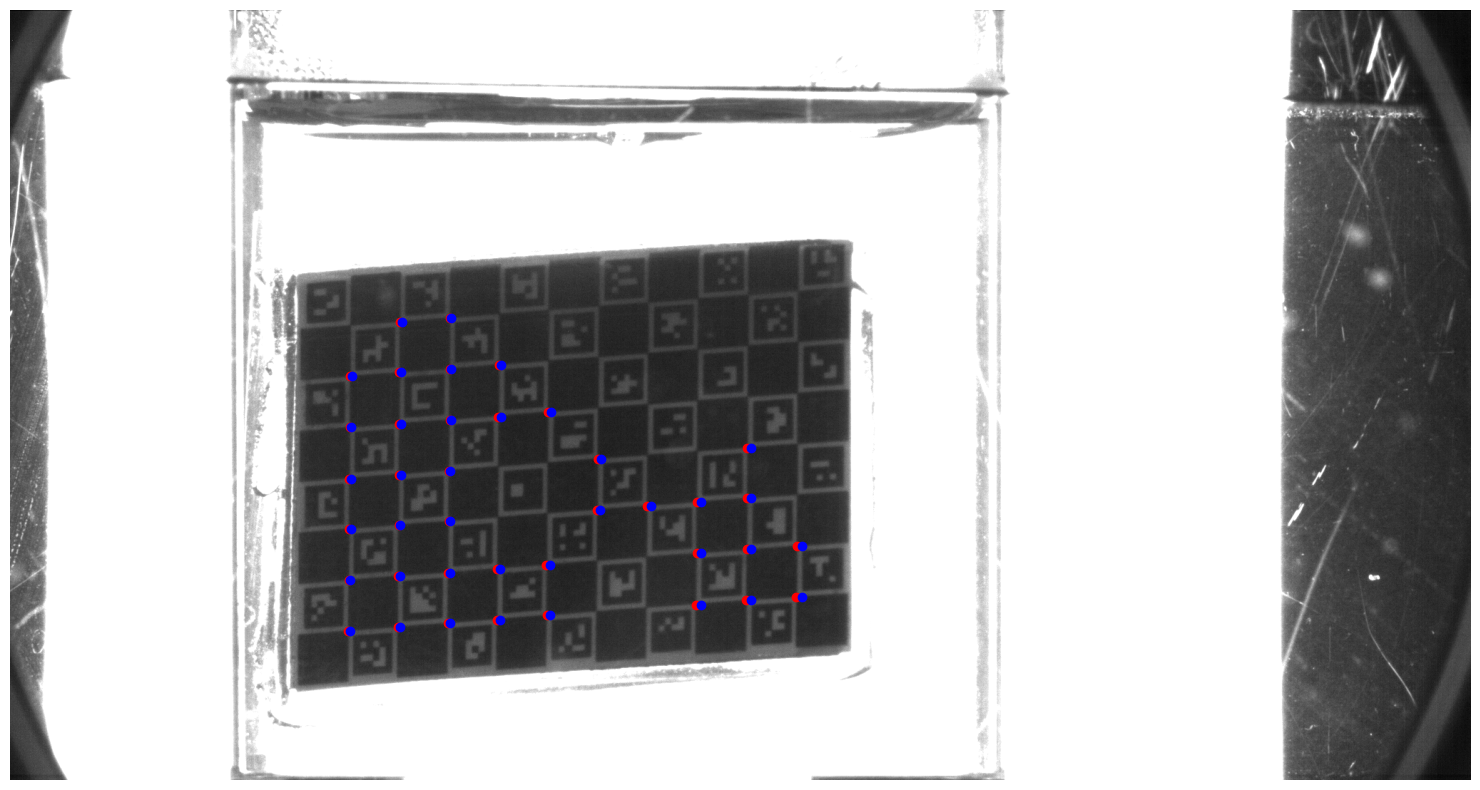

In [51]:
# Add points to the image and draw circles
plt.figure(figsize=(20,10))
plt.imshow(gray, cmap=plt.cm.gray)
plt.scatter(charuco_corners[:, 0, 0], charuco_corners[:, 0, 1], color='r')
plt.scatter(reprojectedPoints[:, 0, 0], charuco_corners[:, 0, 1], color='b')
plt.axis(False)

(6, 9, 2035, 1067)


True

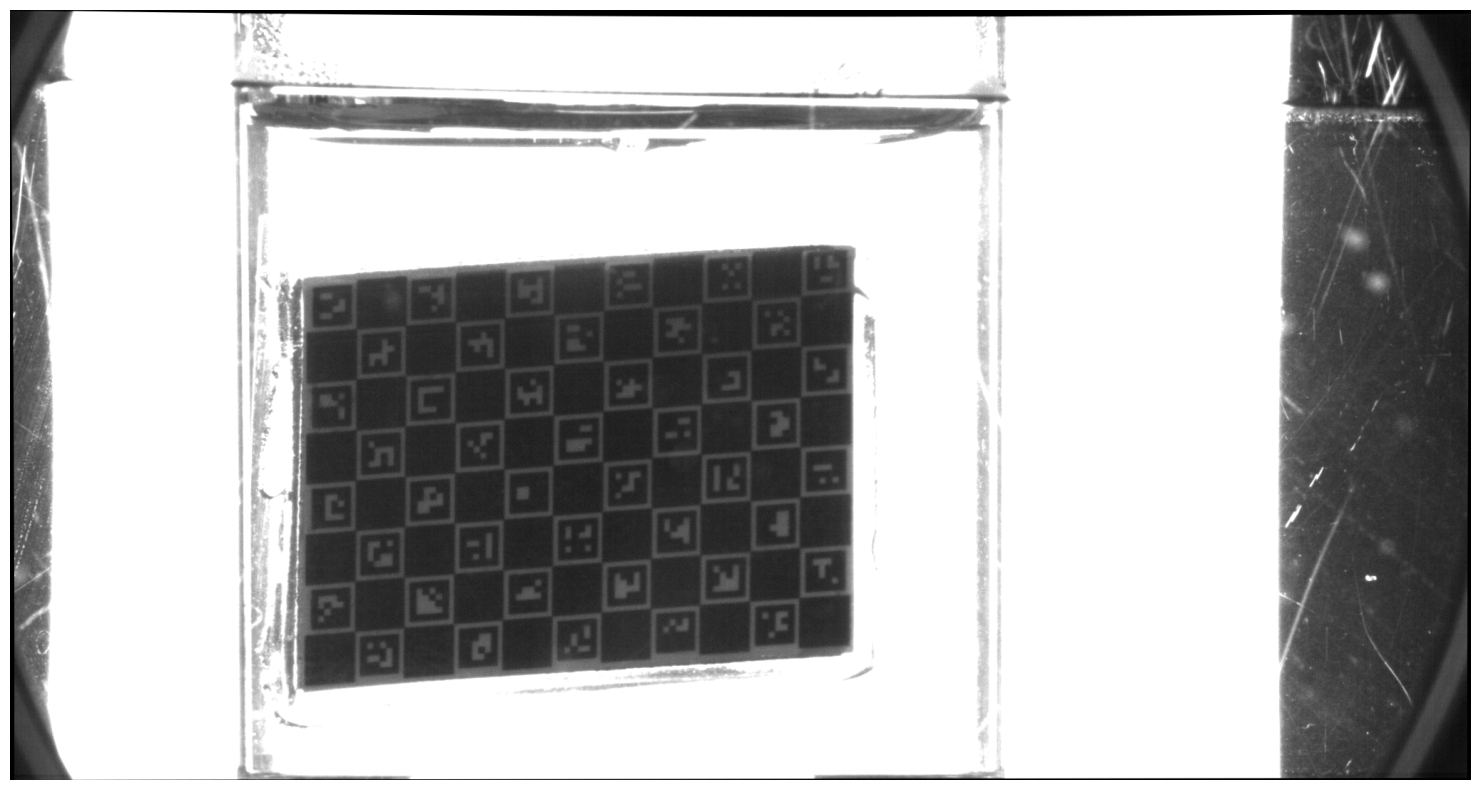

In [65]:
# Undistort an image

h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

dst = cv2.undistort(img, mtx, dist, None, newCameraMatrix=newcameramtx)
# crop the image
x, y, w, h = roi
print(roi)
#dst = dst[y:y+h, x:x+w]

plt.figure(figsize=(20,10))
plt.imshow(dst,cmap='gray')
plt.axis(False)
cv2.imwrite('calibresult.png', dst)

In [66]:
print(img.shape)
print(dst.shape)

(1080, 2048)
(1080, 2048)


In [74]:
def viz_diff_reproject(ori_img,dst):
    diff = dst-img
    print(np.max(diff))
    print(np.min(diff))
    
    plt.figure(figsize=(20,10))
    plt.imshow(diff,cmap='gray')
    plt.colorbar()
    plt.axis(False)

255
0


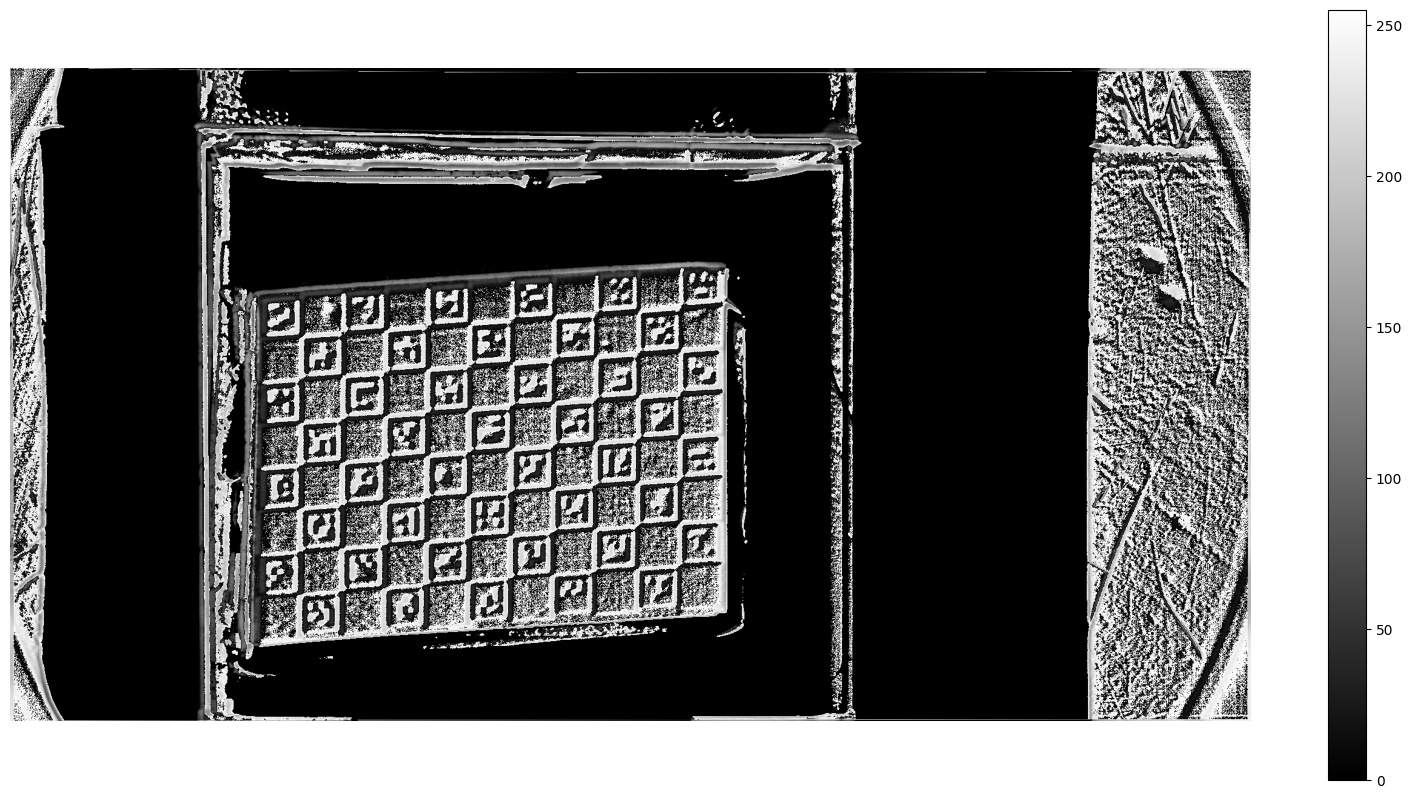

In [75]:
viz_diff_reproject(img,dst)
# dst always >= original img????